<a href="https://colab.research.google.com/github/jmo2171/ml-climate/blob/main/src/wildfire_causal_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
! pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12


In [ ]:
!pip install scikit-learn==1.4.2
# do why requires an older version of sklearn
import sklearn
print(sklearn.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
1.4.2


In [ ]:
import pandas as pd
import dowhy
from dowhy import CausalModel, gcm
import networkx as nx
import numpy as np
from dowhy.gcm.falsify import FalsifyConst, falsify_graph, plot_local_insights, run_validations, apply_suggestions

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# load data

In [ ]:
data = pd.read_csv("long_2000_mean_fire_earth_data.csv")

# causal model

In [ ]:
print(data.columns.tolist())
drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
data = data.drop(columns=drop_cols)

['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'CONT_DATE', 'DURATION_DAYS', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'date', 'dead_fuel_100', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index']


In [ ]:
# Mapping dictionary
class_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}

# Apply the mapping
data['FIRE_SIZE_CLASS_NUM'] = data['FIRE_SIZE_CLASS'].map(class_mapping)
print(data.shape[0])
data = data.dropna()
print(data.shape[0])

61200
58241


In [ ]:
data_np = data.to_numpy()

# Ary's Trials

In [ ]:
ary_data = data.drop(columns=['dead_fuel_1000',
                              'energy_release',
                              #'population_density',
                              'drought_index',
                              #'vegetation',
                              #'precipitation',
                              #'wind_speed',
                              'max_temp_C',
                              'DISCOVERY_DOY',
                              'CONT_DATE',
                              'DURATION_DAYS',
                              'FIRE_SIZE_CLASS',
                              'FIRE_SIZE'
                              ])
ary_data = ary_data.dropna()
ary_data_np = ary_data.to_numpy()

## FIRE_SPREAD Causal Search



  0%|          | 0/7 [00:00<?, ?it/s]

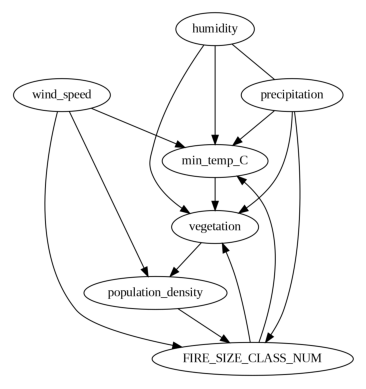

In [ ]:
from causallearn.search.ConstraintBased.PC import pc

labels = [f'{col}' for i, col in enumerate(ary_data.columns)]
ary_data_np = ary_data.to_numpy()

cg = pc(ary_data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

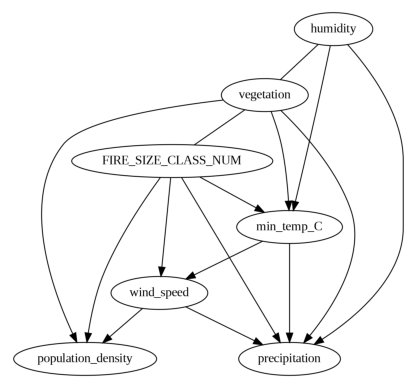

In [ ]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(ary_data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

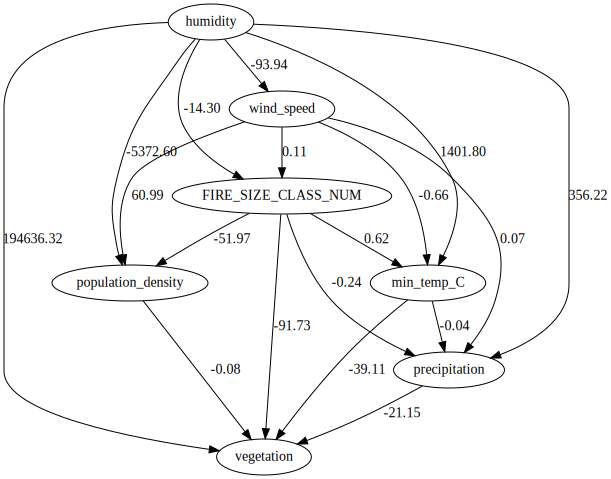

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(ary_data_np)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

## Model x

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import dowhy.gcm as gcm
from dowhy.gcm.ml import SklearnRegressionModel

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]
Test permutations of given graph: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


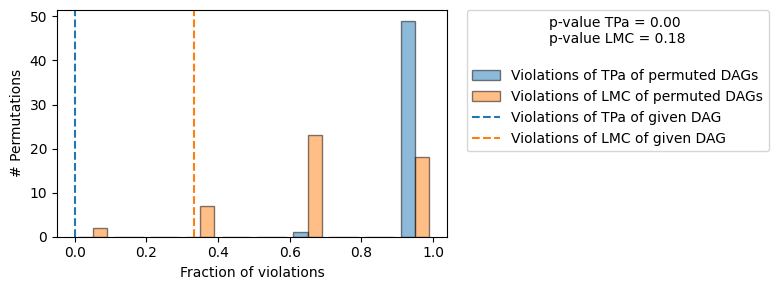

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# Define causal graph
causal_graph = nx.DiGraph([
    ('humidity','min_temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
    ('humidity','vegetation'),
    ('humidity','FIRE_SIZE_CLASS_NUM'),

    ('precipitation','wind_speed'),
    ('precipitation','min_temp_C'),
    ('precipitation','vegetation'),
    ('precipitation','FIRE_SIZE_CLASS_NUM'),

    ('wind_speed','min_temp_C'),
    ('wind_speed','population_density'),
    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('min_temp_C','vegetation'),
    ('min_temp_C','population_density'),
    ('min_temp_C','FIRE_SIZE_CLASS_NUM'),

    ('population_density','vegetation'),
    ('population_density','FIRE_SIZE_CLASS_NUM'),

    ('vegetation','FIRE_SIZE_CLASS_NUM'),
])

# Create causal model
causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, ary_data)

'''
# Root node (no parents)
causal_model.set_causal_mechanism('humidity', gcm.EmpiricalDistribution())

# Internal nodes (with parents)
causal_model.set_causal_mechanism('precipitation',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(HistGradientBoostingRegressor(max_iter=100)))
)

causal_model.set_causal_mechanism('wind_speed',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(HistGradientBoostingRegressor(max_iter=100)))
)

causal_model.set_causal_mechanism('min_temp_C',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(HistGradientBoostingRegressor(max_iter=100)))
)

causal_model.set_causal_mechanism('population_density',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(HistGradientBoostingRegressor(max_iter=100)))
)

causal_model.set_causal_mechanism('vegetation',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(HistGradientBoostingRegressor(max_iter=100)))
)

# Final outcome node
causal_model.set_causal_mechanism('FIRE_SIZE',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(
        make_pipeline(PolynomialFeatures(degree=2), RidgeCV())
    ))
)
'''

# Fit and evaluate
gcm.fit(causal_model, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model, ary_data)
print(evaluation)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node population_density: 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]
Evaluating causal mechanisms...: 100%|██████████| 7/7 [01:54<00:00, 16.32s/it]

Test permutations of given graph: 100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


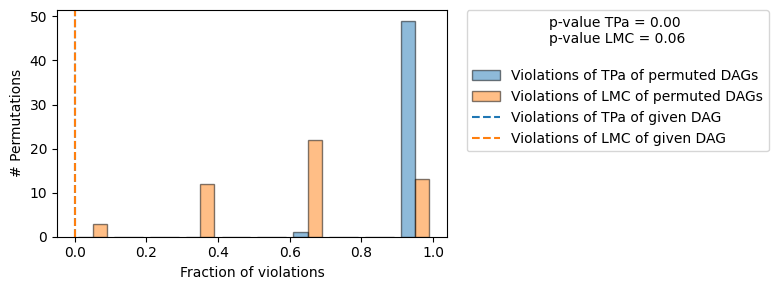

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# Define causal graph
causal_graph = nx.DiGraph([
    ('humidity','min_temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
    ('humidity','vegetation'),
    ('humidity','FIRE_SIZE'),

    ('precipitation','wind_speed'),
    ('precipitation','min_temp_C'),
    ('precipitation','vegetation'),
    ('precipitation','FIRE_SIZE'),

    ('wind_speed','min_temp_C'),
    ('wind_speed','population_density'),
    ('wind_speed','FIRE_SIZE'),

    ('min_temp_C','vegetation'),
    ('min_temp_C','population_density'),
    ('min_temp_C','FIRE_SIZE'),

    ('population_density','vegetation'),
    ('population_density','FIRE_SIZE'),

    ('vegetation','FIRE_SIZE'),
])

# Create causal model
causal_model = gcm.StructuralCausalModel(causal_graph)

auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, ary_data)
print(auto_assignment_summary)

# Fit and evaluate
gcm.fit(causal_model, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model, ary_data)
print(evaluation)

## Model 1

Using RF for most variables, Poly Ridge for FIRE_SIZE

In [ ]:
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('min_temp_C','FIRE_SIZE'),
    ('wind_speed','min_temp_C'),
    ('wind_speed','FIRE_SIZE'),
    ('precipitation','wind_speed'),
    ('precipitation','min_temp_C'),
    ('precipitation','FIRE_SIZE'),
    ('humidity','min_temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
#auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, ary_data)
#print(auto_assignment_summary)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import dowhy.gcm as gcm
from dowhy.gcm.ml import SklearnRegressionModel

# Assign custom causal mechanisms using node objects
causal_model.set_causal_mechanism(
    'FIRE_SIZE', gcm.AdditiveNoiseModel(SklearnRegressionModel(
        make_pipeline(PolynomialFeatures(degree=2), RidgeCV())
    ))
)

causal_model.set_causal_mechanism('min_temp_C', gcm.AdditiveNoiseModel(SklearnRegressionModel(
    RandomForestRegressor(max_depth=5)
)))

causal_model.set_causal_mechanism('wind_speed', gcm.AdditiveNoiseModel(SklearnRegressionModel(
    RandomForestRegressor(n_estimators=100)
)))

causal_model.set_causal_mechanism('precipitation', gcm.AdditiveNoiseModel(SklearnRegressionModel(
    RandomForestRegressor(n_estimators=100)
)))

causal_model.set_causal_mechanism('humidity', gcm.EmpiricalDistribution())

Evaluating causal mechanisms...: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Test permutations of given graph: 100%|██████████| 50/50 [00:00<00:00, 724.45it/s]


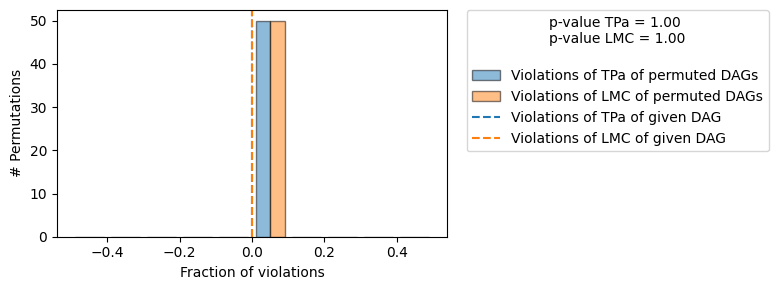

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
gcm.fit(causal_model, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model, ary_data)
print(evaluation)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Test permutations of given graph: 100%|██████████| 20/20 [04:59<00:00, 14.99s/it]


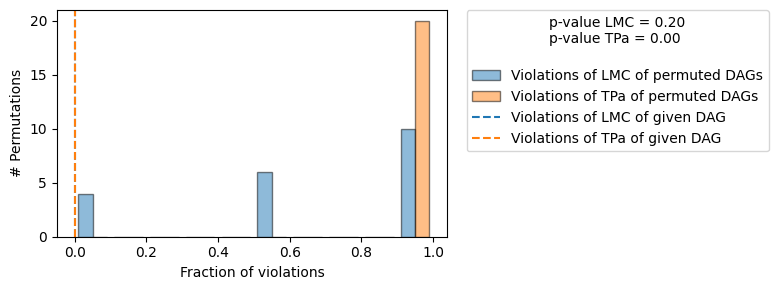

Violations of LMCs


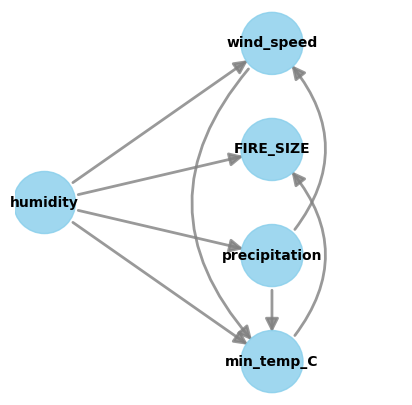

In [ ]:
result = falsify_graph(causal_graph, ary_data, plot_histogram=True, suggestions=True)
print('Violations of LMCs')
plot_local_insights(causal_graph, result, method=FalsifyConst.VALIDATE_LMC)

##Model 2

Using HistGradientBoost for most Variables, Poly Ridge for FIRE_SIZE

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

Test permutations of given graph: 100%|██████████| 50/50 [00:00<00:00, 615.60it/s]


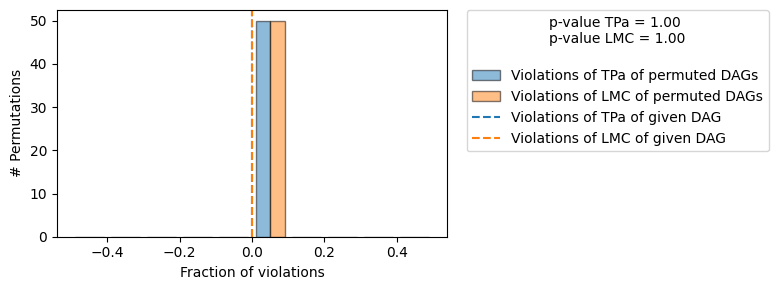

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# Define causal graph
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('min_temp_C','FIRE_SIZE'),
    ('wind_speed','min_temp_C'),
    ('wind_speed','FIRE_SIZE'),
    ('precipitation','wind_speed'),
    ('precipitation','min_temp_C'),
    ('precipitation','FIRE_SIZE'),
    ('humidity','min_temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
])

# Create causal model
causal_model = gcm.StructuralCausalModel(causal_graph)

# Root node (no parents)
causal_model.set_causal_mechanism('humidity', gcm.EmpiricalDistribution())

# Internal nodes (with parents)
causal_model.set_causal_mechanism('precipitation',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(HistGradientBoostingRegressor(max_iter=100)))
)

causal_model.set_causal_mechanism('wind_speed',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(HistGradientBoostingRegressor(max_iter=100)))
)

causal_model.set_causal_mechanism('min_temp_C',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(HistGradientBoostingRegressor(max_iter=100)))
)

# Final outcome node
causal_model.set_causal_mechanism('FIRE_SIZE',
    gcm.AdditiveNoiseModel(SklearnRegressionModel(
        make_pipeline(PolynomialFeatures(degree=2), RidgeCV())
    ))
)

# Fit and evaluate
gcm.fit(causal_model, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model, ary_data)
print(evaluation)

## Model 3

This model is a superstar attempt at including interaction and predicting log fire size to reduce skewness

In [ ]:
import networkx as nx
import dowhy.gcm as gcm
from dowhy.gcm import AdditiveNoiseModel
from dowhy.gcm import EmpiricalDistribution
from dowhy.gcm.ml import SklearnRegressionModel
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_is_fitted

class FeatureAugmentingModel(BaseEstimator):
    def __init__(self, base_model, interaction_terms, feature_names=None):
        self.base_model = base_model
        self.interaction_terms = interaction_terms
        self.feature_names = feature_names

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            if self.feature_names is None:
                raise ValueError("Feature names must be provided when using ndarray.")
            X = pd.DataFrame(X, columns=self.feature_names)
        X_aug = self._augment_features(X)
        self.base_model.fit(X_aug, y)
        self.feature_names_ = X_aug.columns  # save for predict
        return self

    def predict(self, X):
        check_is_fitted(self, 'feature_names_')
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names[:X.shape[1]])
        X_aug = self._augment_features(X)
        return self.base_model.predict(X_aug)

    def _augment_features(self, X):
        X = X.copy()
        for (a, b) in self.interaction_terms:
            if a in X.columns and b in X.columns:
                X[f"{a}_x_{b}"] = X[a] * X[b]
        return X

In [ ]:
# === DATA PREPROCESSING ===
ary_data['log_FIRE_SIZE'] = np.log1p(ary_data['FIRE_SIZE'])

In [ ]:
# Add interaction features directly to the data (not the graph!)
ary_data['humidity_x_precip'] = ary_data['humidity'] * ary_data['precipitation']
ary_data['humidity_x_wind'] = ary_data['humidity'] * ary_data['wind_speed']
ary_data['humidity_x_min_temp'] = ary_data['humidity'] * ary_data['min_temp_C']

Test permutations of given graph: 100%|██████████| 50/50 [00:00<00:00, 621.34it/s]


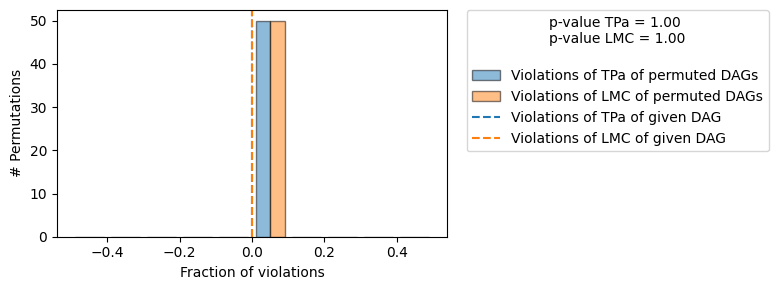

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# === CAUSAL GRAPH (structure preserved) ===
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('min_temp_C','FIRE_SIZE'),
    ('wind_speed','min_temp_C'),
    ('wind_speed','FIRE_SIZE'),
    ('precipitation','wind_speed'),
    ('precipitation','min_temp_C'),
    ('precipitation','FIRE_SIZE'),
    ('humidity','min_temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
])

# === BUILD MODEL ===
causal_model = gcm.StructuralCausalModel(causal_graph)

# Root node
causal_model.set_causal_mechanism('humidity', EmpiricalDistribution())

def get_valid_interactions_for_node(graph, node):
    parents = list(graph.predecessors(node))
    interactions = []
    for i in range(len(parents)):
        for j in range(i + 1, len(parents)):
            interactions.append((parents[i], parents[j]))
    return interactions

for node in causal_graph.nodes:
    if node != 'humidity':
        parents = list(causal_graph.predecessors(node))
        interactions = get_valid_interactions_for_node(causal_graph, node)

        model = FeatureAugmentingModel(
            base_model=HistGradientBoostingRegressor(max_iter=100),
            interaction_terms=interactions,
            feature_names=parents
        )

        causal_model.set_causal_mechanism(
            node,
            AdditiveNoiseModel(SklearnRegressionModel(model))
        )

# === FIT MODEL ===
gcm.fit(causal_model, ary_data)

# === EVALUATE MODEL ===
evaluation = gcm.evaluate_causal_model(causal_model, ary_data)
print(evaluation)

## FIRE_SIZE_CLASS prediction

In [ ]:
ary_data = data.drop(columns=['dead_fuel_1000',
                              'energy_release',
                              'population_density',
                              'drought_index',
                              'vegetation',
                              #'precipitation',
                              #'wind_speed',
                              'max_temp_C',
                              'DISCOVERY_DOY',
                              'CONT_DATE',
                              'DURATION_DAYS',
                              'FIRE_SIZE',
                              ])
ary_data = ary_data.dropna()
ary_data_np = ary_data.to_numpy()

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(ary_data_np)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

ValueError: could not convert string to float: 'A'

## Model N

In [ ]:
ary_data = data.drop(columns=[#'dead_fuel_1000',
                              'energy_release',
                              'population_density',
                              'drought_index',
                              'vegetation',
                              #'precipitation',
                              #'wind_speed',
                              'max_temp_C',
                              #'humidity'
                              ])
ary_data = ary_data.dropna()
ary_data_np = ary_data.to_numpy()

  0%|          | 0/6 [00:00<?, ?it/s]

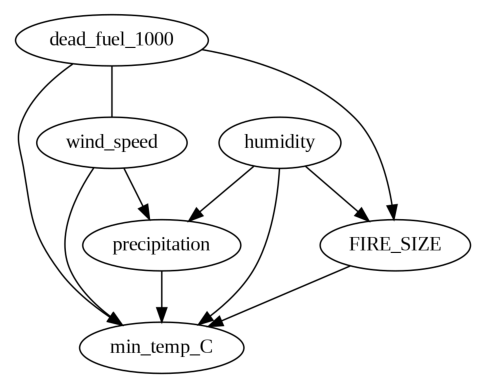

In [ ]:
from causallearn.search.ConstraintBased.PC import pc

labels = [f'{col}' for i, col in enumerate(ary_data.columns)]
ary_data_np = ary_data.to_numpy()

cg = pc(ary_data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

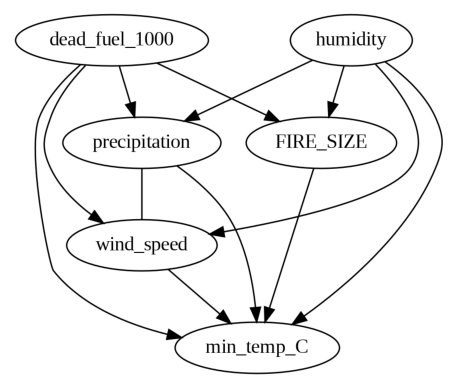

In [ ]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(ary_data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

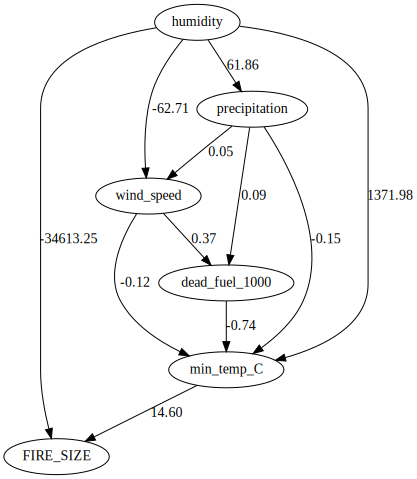

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(ary_data_np)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

In [ ]:
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('humidity','min_temp_C'),
    ('humidity','wind_speed'),
    ('humidity','precipitation'),
    ('min_temp_C','FIRE_SIZE'),
    ('wind_speed','min_temp_C'),
    ('wind_speed','dead_fuel_1000'),
    ('precipitation','wind_speed'),
    ('precipitation','min_temp_C'),
    ('precipitation','dead_fuel_1000'),
    ('dead_fuel_1000','min_temp_C'),
])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, ary_data)
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Test permutations of given graph: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


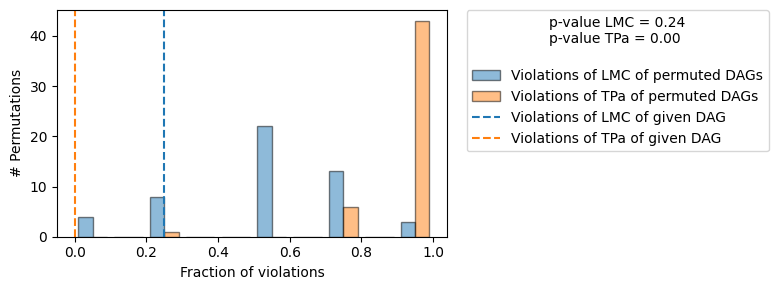

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
gcm.fit(causal_model, ary_data)
evaluation = gcm.evaluate_causal_model(causal_model, ary_data)
print(evaluation)

In [ ]:
result = falsify_graph(causal_graph, ary_data, plot_histogram=True, suggestions=True)
print('Violations of LMCs')
plot_local_insights(causal_graph, result, method=FalsifyConst.VALIDATE_LMC)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Test permutations of given graph:   5%|▌         | 1/20 [01:34<29:59, 94.71s/it]


KeyboardInterrupt: 

# Jenny's Trials

## unused

In [ ]:
causal_graph1 = """
digraph {
    humidity -> FIRE_SIZE;
    precipitation -> FIRE_SIZE;
    wind_speed -> FIRE_SIZE;
    drought_index -> FIRE_SIZE;
    dead_fuel_1000 -> FIRE_SIZE;
    energy_release -> FIRE_SIZE;
    max_temp_C -> FIRE_SIZE;
    min_temp_C -> FIRE_SIZE;
    vegetation -> FIRE_SIZE;
    population_density -> FIRE_SIZE;
    drought_index -> dead_fuel_1000;
}
"""


In [ ]:
# model = CausalModel(
#     data=data,
#     treatment=['humidity', 'precipitation', 'wind_speed', 'dead_fuel_1000', 'drought_index'],
#     outcome='FIRE_SIZE',
#     graph=causal_graph1
# )

# # Visualize the model
# model.view_model()

# # Identify causal effect
# identified_estimand = model.identify_effect()

# # Estimate causal effect
# causal_estimate = model.estimate_effect(
#     identified_estimand,
#     method_name="backdoor.linear_regression"
# )

# print(causal_estimate)


## first pass

In [ ]:
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('humidity','dead_fuel_1000'),
    ('precipitation','FIRE_SIZE'),
    ('precipitation','humidity'),
    ('precipitation','drought_index'),
    ('precipitation','vegetation'),
    ('wind_speed','FIRE_SIZE'),
     ('drought_index','FIRE_SIZE'),
      ('drought_index','energy_release'),
       ('drought_index','vegetation'),
        ('dead_fuel_1000','FIRE_SIZE'),
         ('dead_fuel_1000','energy_release'),
          ('energy_release','FIRE_SIZE'),
           ('max_temp_C','humidity'),
           ('max_temp_C','drought_index'),
            ('min_temp_C','humidity'),
             ('vegetation','dead_fuel_1000'),
              ('population_density','FIRE_SIZE'),
               ('population_density','vegetation'),
                ('drought_index','dead_fuel_1000'),
                 ('drought_index','vegetation')
])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)


In [ ]:
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
print(auto_assignment_summary)


When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [ ]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [ ]:
gcm.fit(causal_model, data)


Fitting causal mechanism of node population_density: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


Test permutations of given graph: 100%|██████████| 50/50 [05:19<00:00,  6.40s/it]


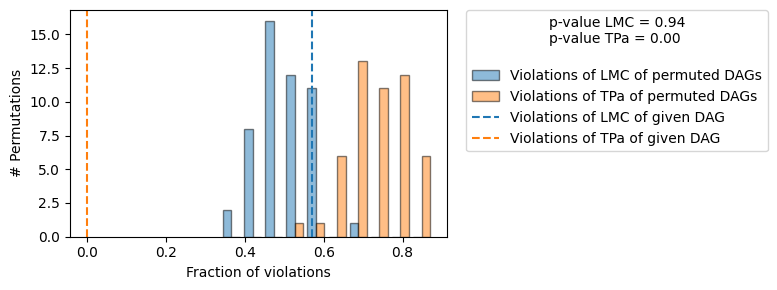

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
print(gcm.evaluate_causal_model(causal_model, data))


# causal discovery

  0%|          | 0/11 [00:00<?, ?it/s]

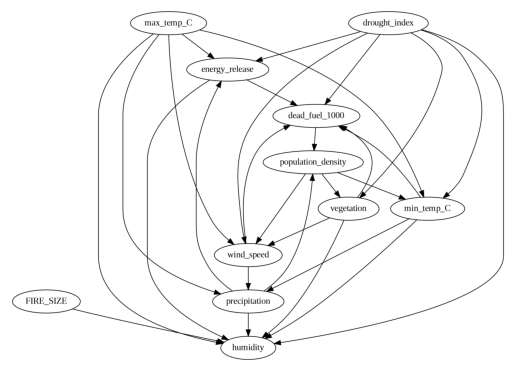

In [ ]:
from causallearn.search.ConstraintBased.PC import pc

labels = [f'{col}' for i, col in enumerate(data.columns)]
data_np = data.to_numpy()

cg = pc(data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

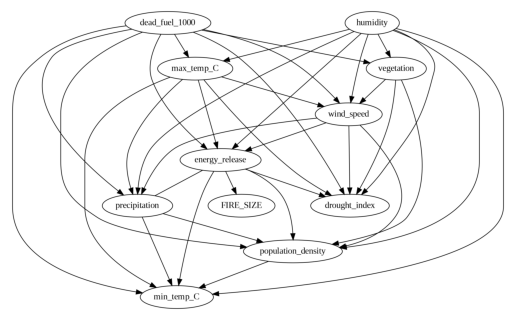

In [ ]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

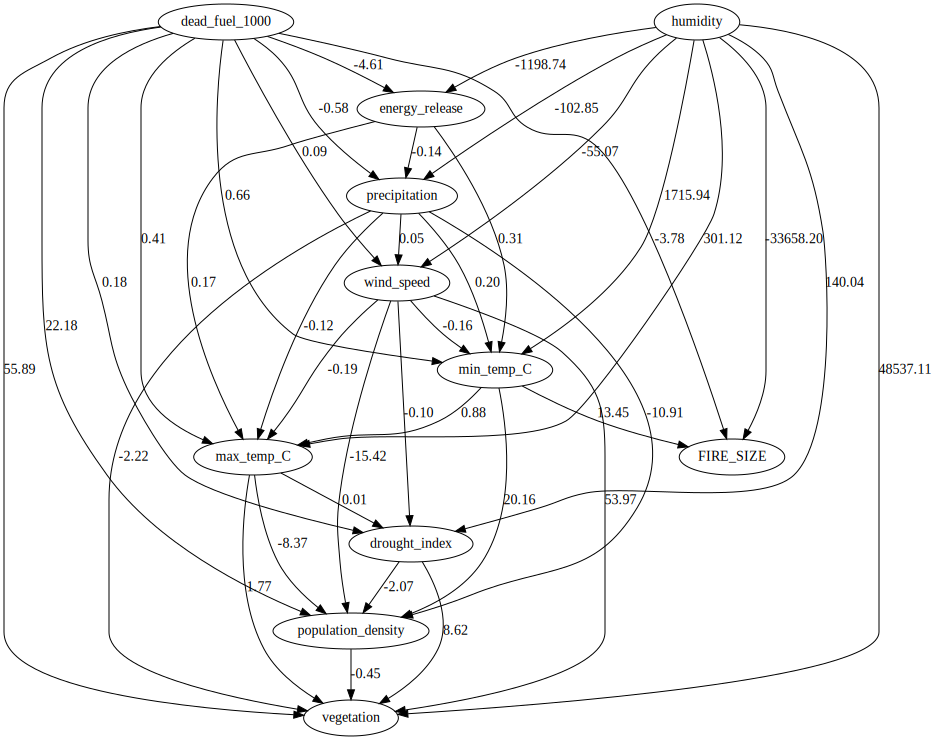

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data_np)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)